In [1]:
%load_ext autoreload
%autoreload 2
import torch
torch.manual_seed(0) # Set seed before importing other modules
import numpy as np
np.random.seed(0)
import random
random.seed(0)
import sys
import os
import lightning.pytorch as pl
from utils.get_data import get_dataloader_augmented
from utils.visualisations import evaluate_models, pca_plot_dataloaders, pca_plot_multiclass, visualize_prediction_matrix
import torch.multiprocessing
from models.dino import MultiModalDINO, MultiModalDINOLightning, \
                        ViTMultiModalEncoder, LSTMMultiModalEncoder, \
                        SimpleMultiModalEncoder, CrossAttentionMultiModalEncoder, \
                        DualViTMultiModalEncoder, CrossAttentionViTMultiModalEncoder, \
                        UniModalDINOLightning, ImageEncoder, SpectrogramEncoder, SpectrogramEncoderResNet
from utils.get_data import get_dataloader_augmented
from training_structures.dino_train import train_downstream, train_knn_classifier 
# torch.multiprocessing.set_start_method('spawn')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
current_path = os.getcwd()
model_name = 'dino_unimodal_audio_clean_resnet18_no_pretrain_20250318_172127'
model_files_path = os.path.join(current_path, 'model_saves', model_name)
pca_plot_path = os.path.join(model_files_path, 'pca_plots')
confusion_matrix_path = os.path.join(model_files_path, 'confusion_matrix')
plots_trials_path = os.path.join(model_files_path, 'plots_trials')
model_versions_path = os.path.join(model_files_path, 'versions')
# final_model_path = os.path.join(model_files_path, 'dino_gated_vit_audio_cnn_image.ckpt')
best_model_path = os.path.join(model_files_path, 'epoch=1-step=860.ckpt')
sys.path.append(current_path)

In [2]:
# traindata, validdata, testdata = get_dataloader_augmented(f'{current_path}/data/avmnist', type="burst_noise", batch_size=128, num_workers=0)

# # List of model directories to evaluate
# model_dirs = {
#     # "dino_gated_vit_audio_cnn_image_20250305": ViTMultiModalEncoder,
#     # "final_dino_cnn-lstm_audio_cnn_image_20250305_230356": LSTMMultiModalEncoder,
#     # "final_multimodal_dino_20250226_220312": SimpleMultiModalEncoder, # NOTE: idk which model this is
#     # "final_multimodal_dino_bidirectional_cross_gated_20250304_221056": CrossAttentionMultiModalEncoder,
#     # "final_multimodal_dino_bidirectional_cross_fusion_20250304_212310": CrossAttentionMultiModalEncoder(), # TODO: 
#     # "final_multimodal_dino_unidirectional_cross_fusion_20250304_204149": MultiModalDINO(),
#     "final_multimodal_dino_vit_20250227_163413": DualViTMultiModalEncoder,
# }

# model_dirs_unimodal = {
#     "final_dino_unimodal_image_20250309_151758": ImageEncoder,
#     "final_dino_unimodal_audio_20250309_154754": SpectrogramEncoder,
# }

# # Evaluate all models
# summary = evaluate_models(
#     model_dirs=model_dirs,
#     dataloaders=(traindata, validdata, testdata),
#     output_base_dir="model_evaluation_results",
#     device="cuda"
# )

# print("Evaluation complete!")

In [3]:
# module = MultiModalDINOLightning.load_from_checkpoint(best_model_path, encoder_class=CrossAttentionViTMultiModalEncoder)
module = UniModalDINOLightning.load_from_checkpoint(best_model_path, encoder_class=SpectrogramEncoderResNet, strict=False)  # This will ignore unexpected keys
pretrained_dino = module.model
# print("audio: \n", pretrained_dino.student.gate_audio, "\nimage: \n", pretrained_dino.student.gate_image)
# pretrained_dino.student.gate for ViT one

c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\lightning\pytorch\core\saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['model.student.encoder.0.conv1.weight', 'model.student.encoder.0.bn1.weight', 'model.student.encoder.0.bn1.bias', 'model.student.encoder.0.bn1.running_mean', 'model.student.encoder.0.bn1.running_var', 'model.student.encoder.0.layer1.0.conv1.weight', 'model.student.encoder.0.layer1.0.bn1

In [4]:
traindata, validdata, testdata = get_dataloader_augmented(f'{current_path}/data/avmnist', type="burst_noise", batch_size=128, num_workers=0)
knn_model, knn_accuracy = train_knn_classifier(pretrained_dino, traindata, testdata, n_neighbors=5)

Extracting training features...
Extracting test features...
Training KNN classifier...
KNN Accuracy (k=5): 0.1311


In [5]:
classifier = train_downstream(
    pretrained_dino,
    traindata,
    validdata,
    testdata,
    num_epochs=10,
    device=device,
    save_path=f'model_saves/dino/downstream/{model_name}.pt',
    train_log_path=f'training_logs/dino/downstream/{model_name}_train_log.csv',
    test_log_path=f'test_logs/dino/downstream/{model_name}_test_log.csv',
)

Epoch 1/10: 100%|██████████| 430/430 [00:13<00:00, 31.71it/s, loss=2.28]


Epoch 1: Train Loss: 2.2649, Val Loss: 2.2403, Val Acc: 15.38%
Saved best model with validation accuracy: 15.38%


Epoch 2/10: 100%|██████████| 430/430 [00:13<00:00, 32.03it/s, loss=2.25]


Epoch 2: Train Loss: 2.2311, Val Loss: 2.2247, Val Acc: 16.86%
Saved best model with validation accuracy: 16.86%


Epoch 3/10: 100%|██████████| 430/430 [00:12<00:00, 35.07it/s, loss=2.24]


Epoch 3: Train Loss: 2.2101, Val Loss: 2.2027, Val Acc: 17.34%
Saved best model with validation accuracy: 17.34%


Epoch 4/10: 100%|██████████| 430/430 [00:12<00:00, 35.04it/s, loss=2.15]


Epoch 4: Train Loss: 2.1985, Val Loss: 2.1949, Val Acc: 18.22%
Saved best model with validation accuracy: 18.22%


Epoch 5/10: 100%|██████████| 430/430 [00:12<00:00, 35.52it/s, loss=2.19]


Epoch 5: Train Loss: 2.1899, Val Loss: 2.1935, Val Acc: 18.48%
Saved best model with validation accuracy: 18.48%


Epoch 6/10: 100%|██████████| 430/430 [00:12<00:00, 34.75it/s, loss=2.14]


Epoch 6: Train Loss: 2.1851, Val Loss: 2.1851, Val Acc: 18.94%
Saved best model with validation accuracy: 18.94%


Epoch 7/10: 100%|██████████| 430/430 [00:12<00:00, 33.94it/s, loss=2.19]


Epoch 7: Train Loss: 2.1807, Val Loss: 2.1851, Val Acc: 19.58%
Saved best model with validation accuracy: 19.58%


Epoch 8/10: 100%|██████████| 430/430 [00:12<00:00, 34.45it/s, loss=2.15]


Epoch 8: Train Loss: 2.1771, Val Loss: 2.1812, Val Acc: 19.62%
Saved best model with validation accuracy: 19.62%


Epoch 9/10: 100%|██████████| 430/430 [00:12<00:00, 35.75it/s, loss=2.24]


Epoch 9: Train Loss: 2.1750, Val Loss: 2.1809, Val Acc: 19.46%


Epoch 10/10: 100%|██████████| 430/430 [00:12<00:00, 35.02it/s, loss=2.14]


Epoch 10: Train Loss: 2.1745, Val Loss: 2.1808, Val Acc: 19.32%


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\training_structures\dino_train.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l


Test Accuracy: 18.31%


100%|██████████| 79/79 [00:01<00:00, 71.36it/s]


Selected digits for visualization: [5, 8]


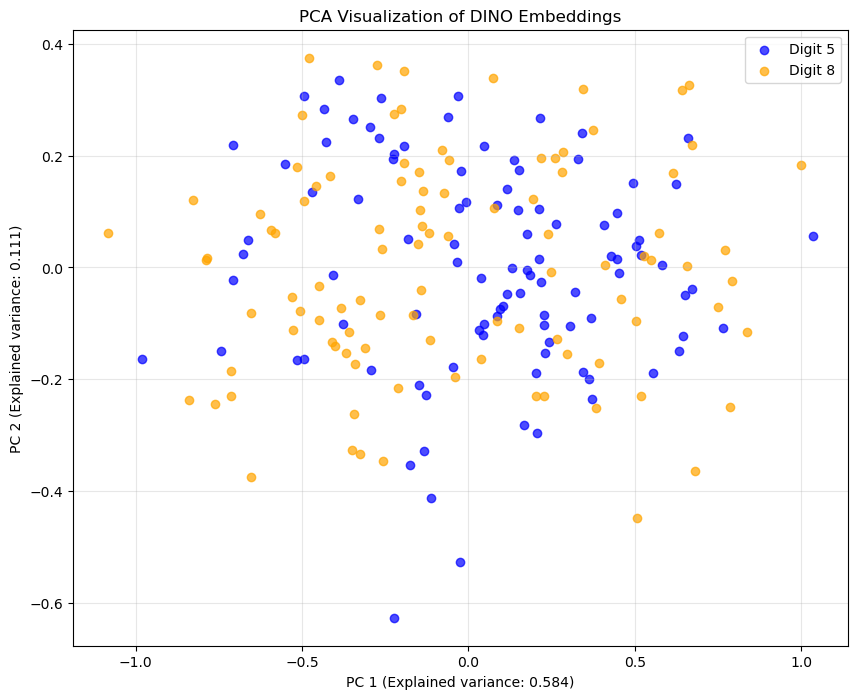

In [6]:
_ = pca_plot_dataloaders(pretrained_dino, testdata, selected_digits=[5, 8], dirpath=pca_plot_path)

100%|██████████| 79/79 [00:01<00:00, 71.31it/s]


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


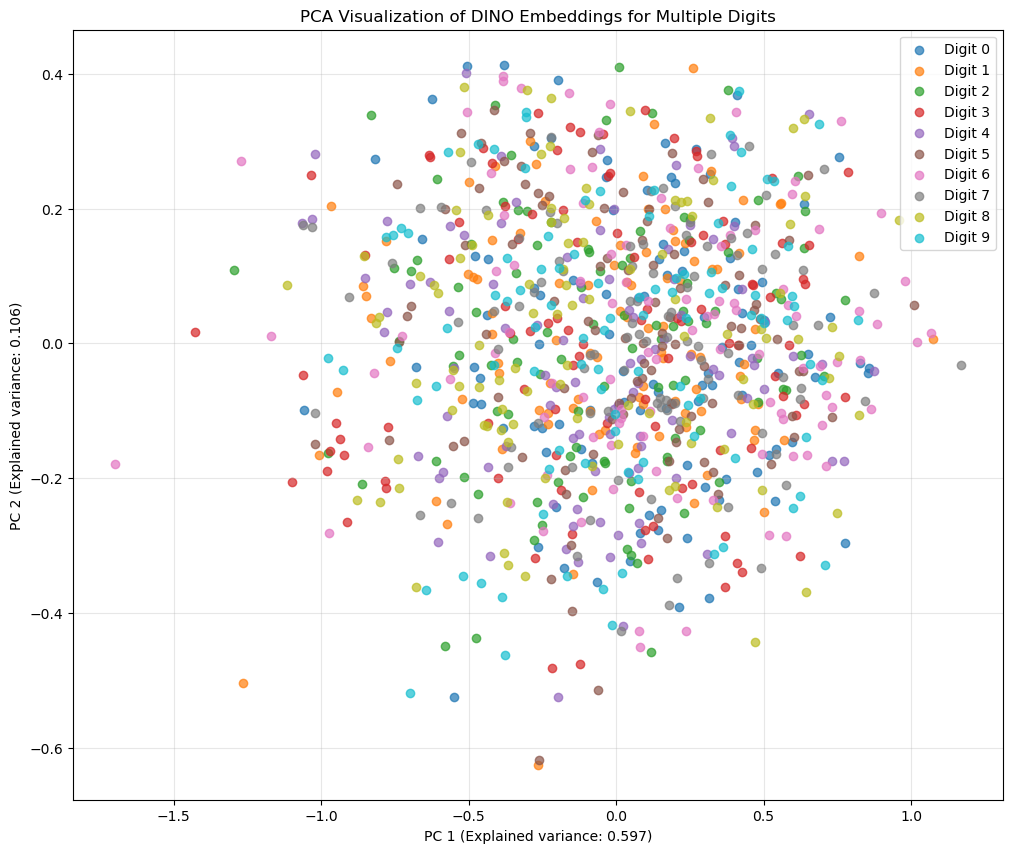

In [7]:
_ = pca_plot_multiclass(pretrained_dino, testdata, selected_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dirpath=pca_plot_path)

100%|██████████| 79/79 [00:01<00:00, 46.18it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

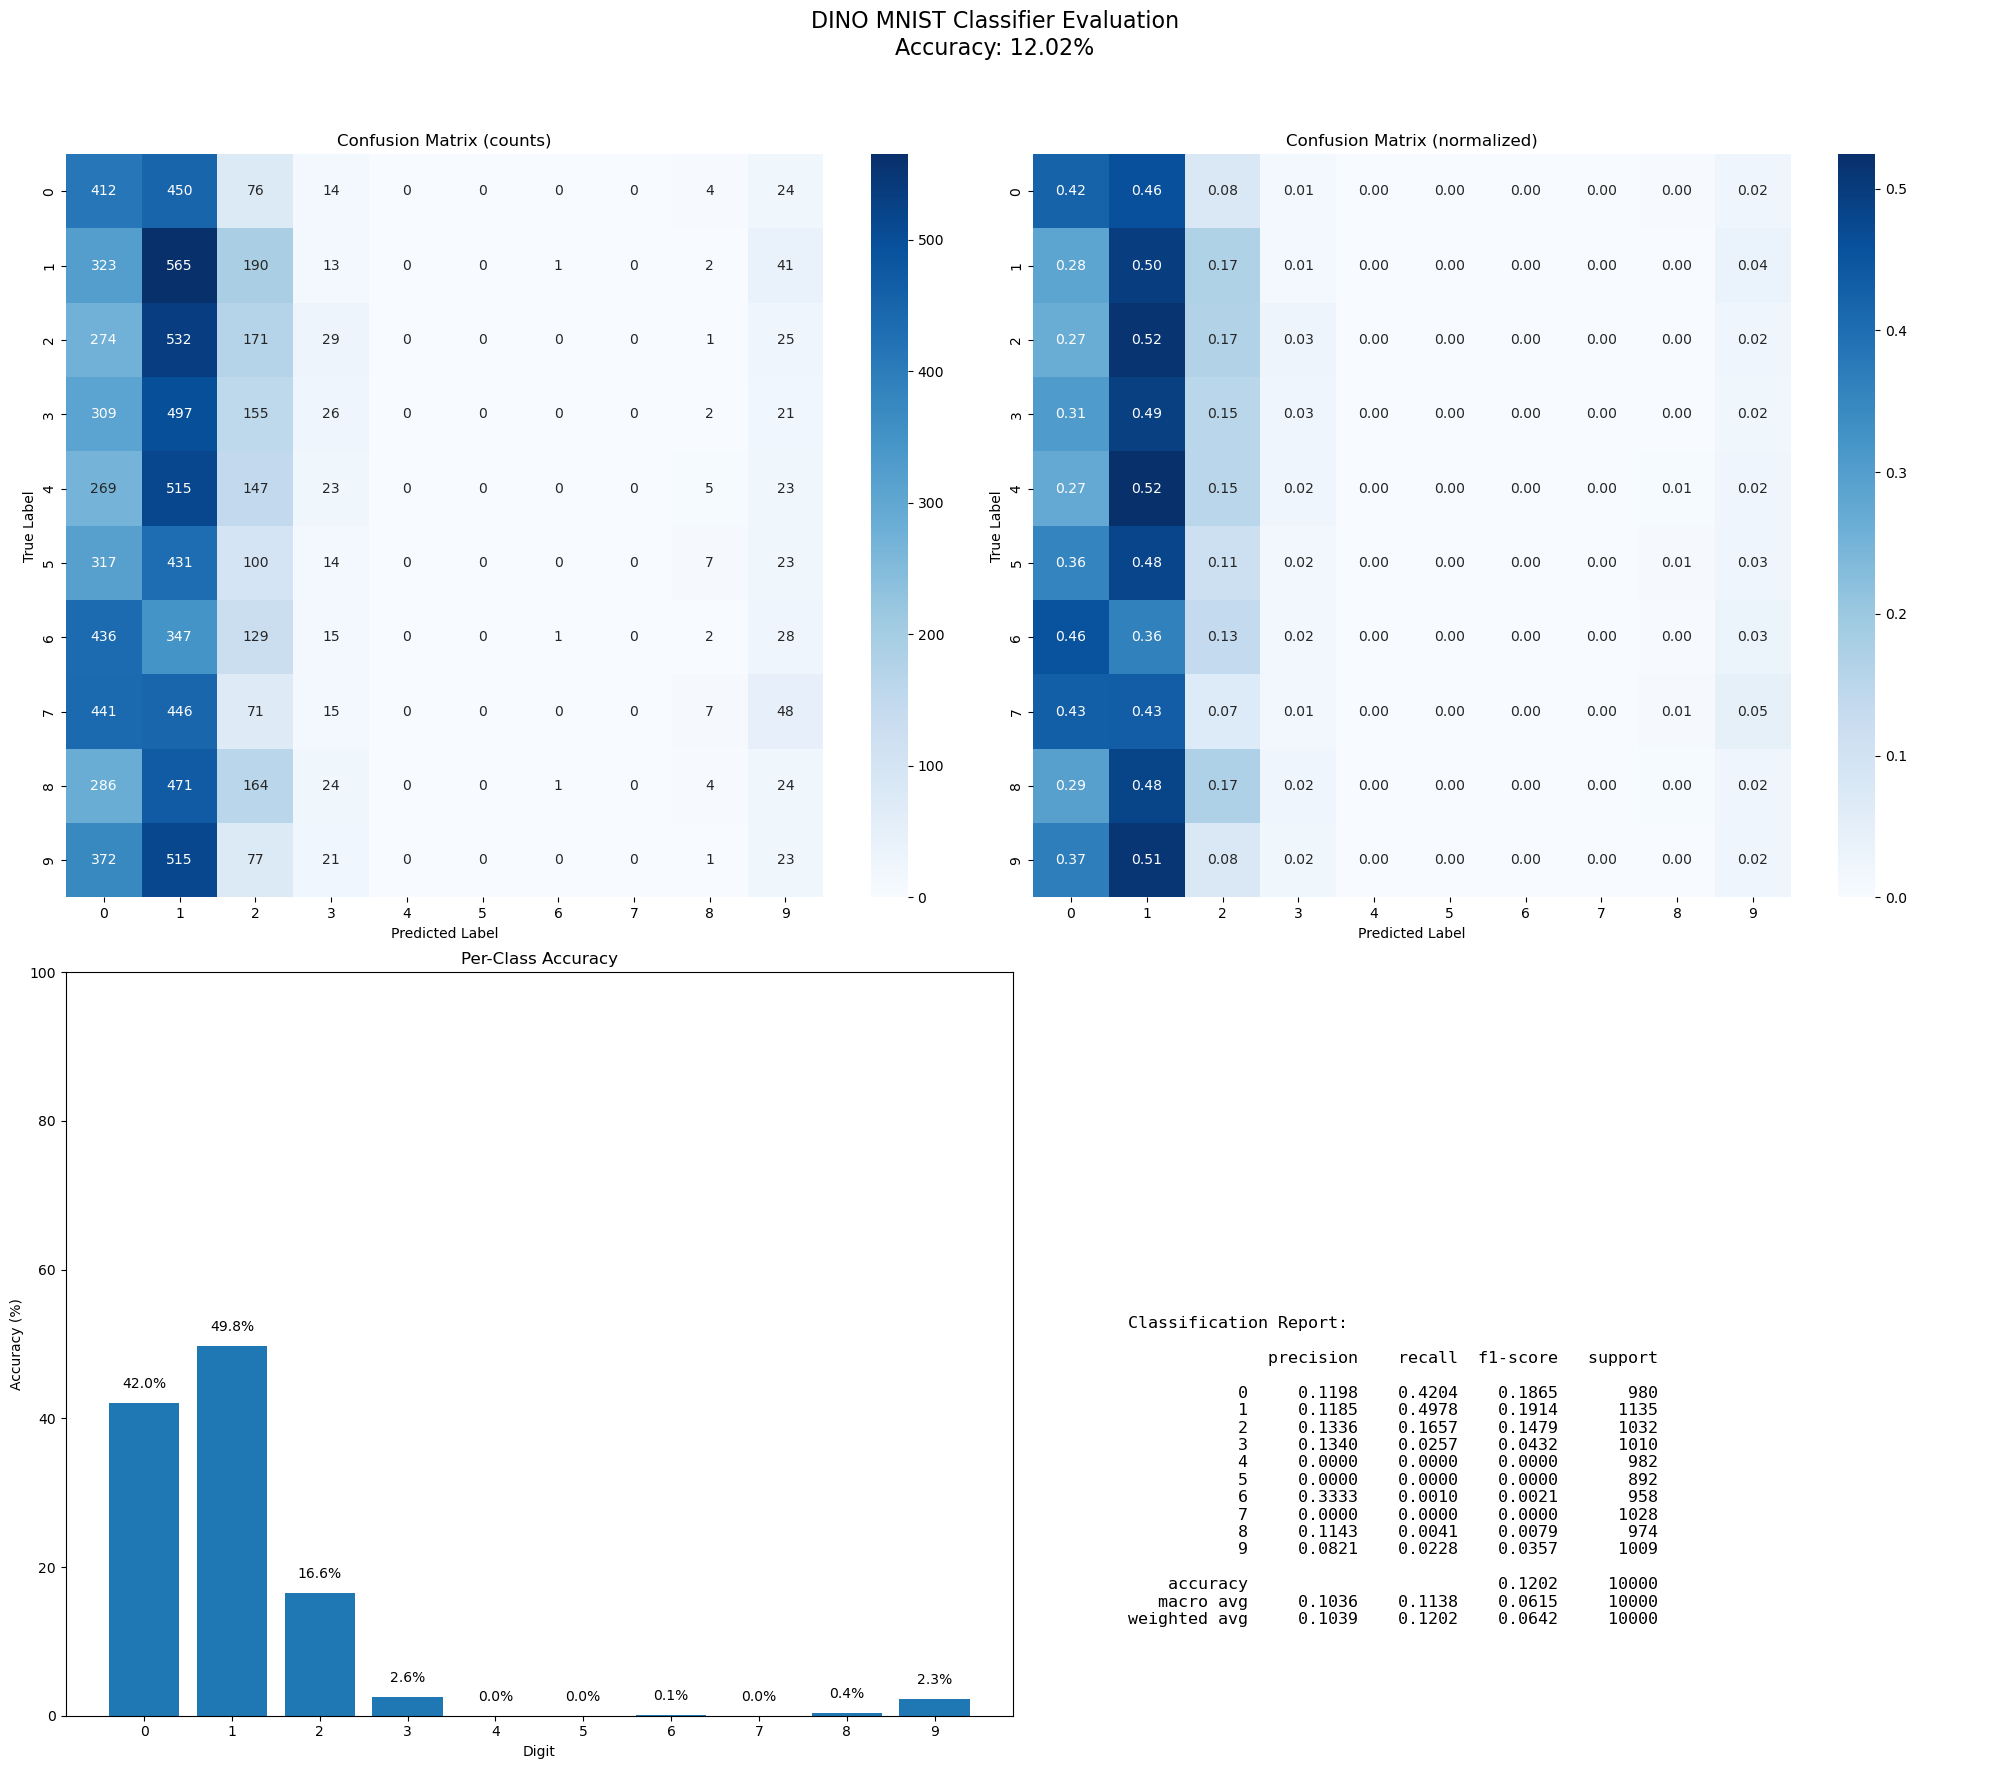

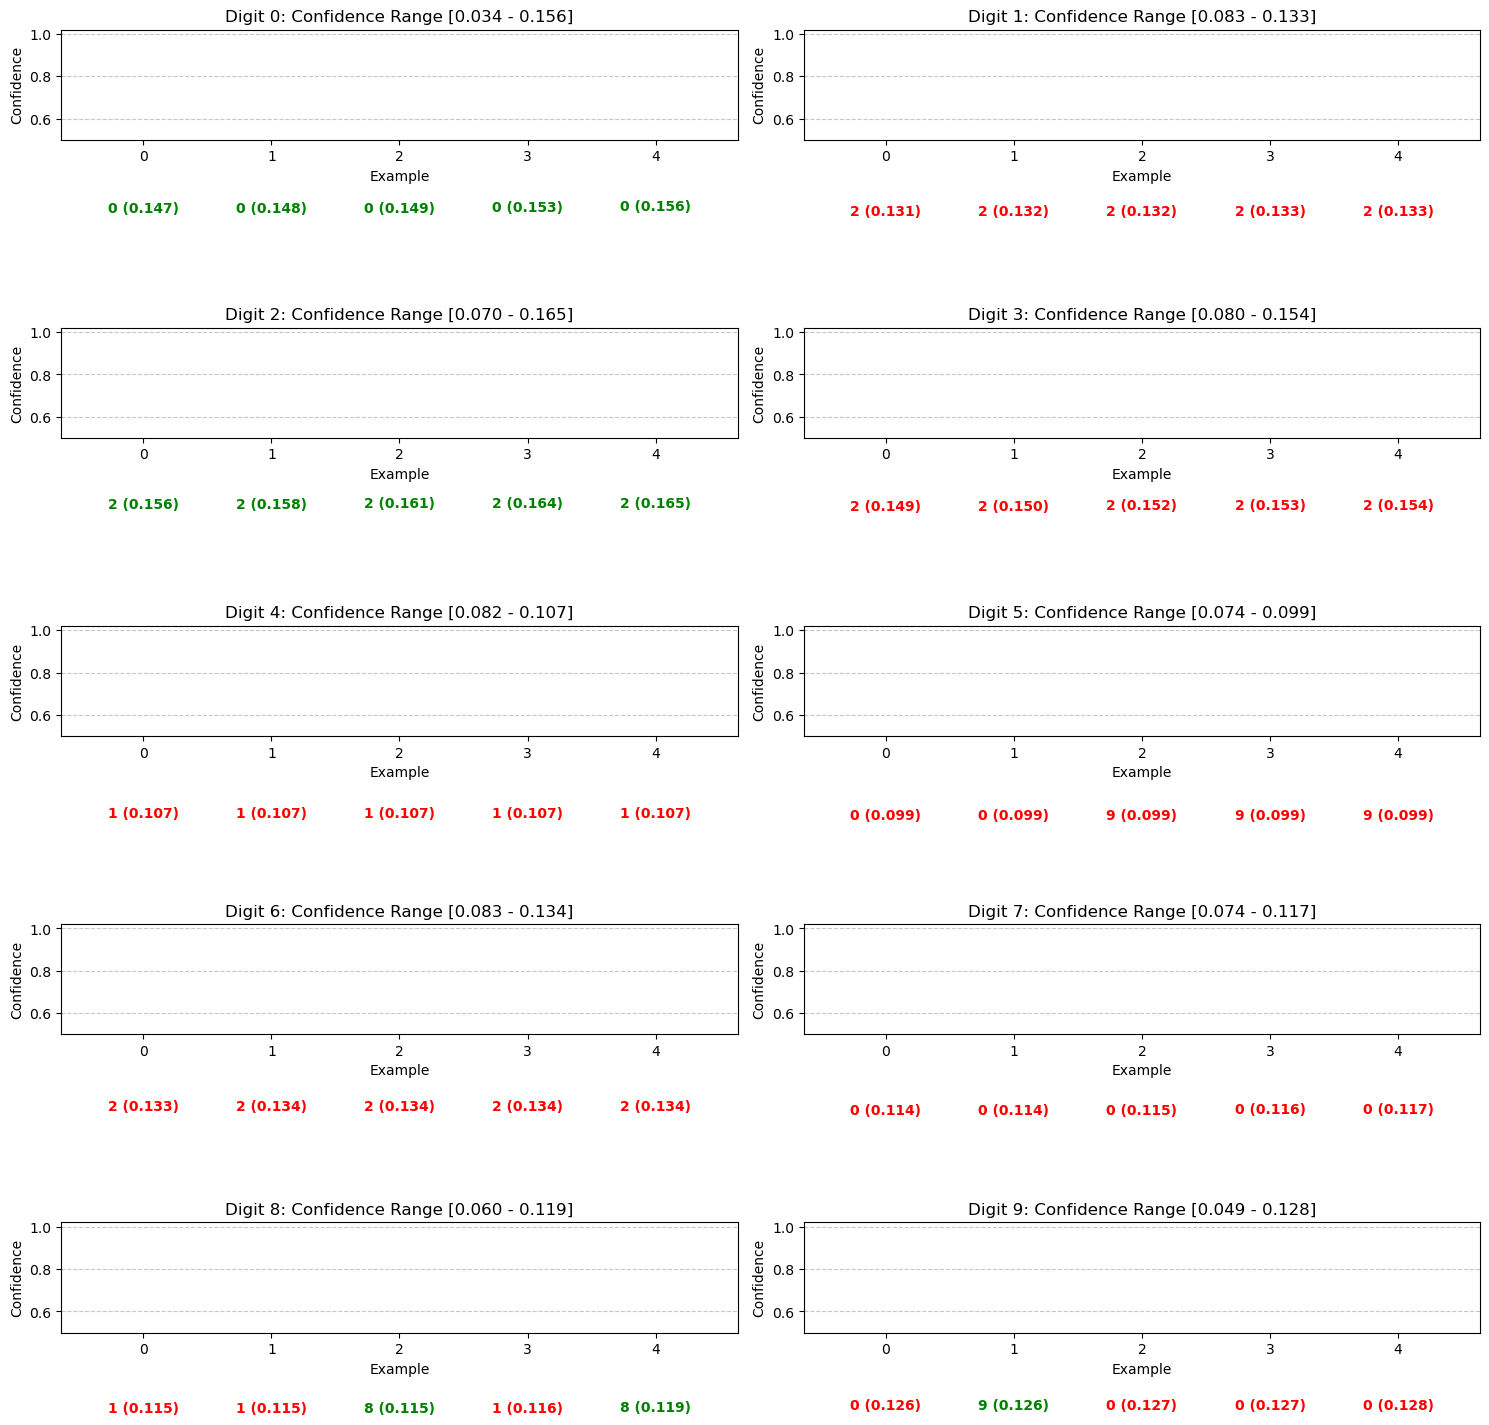

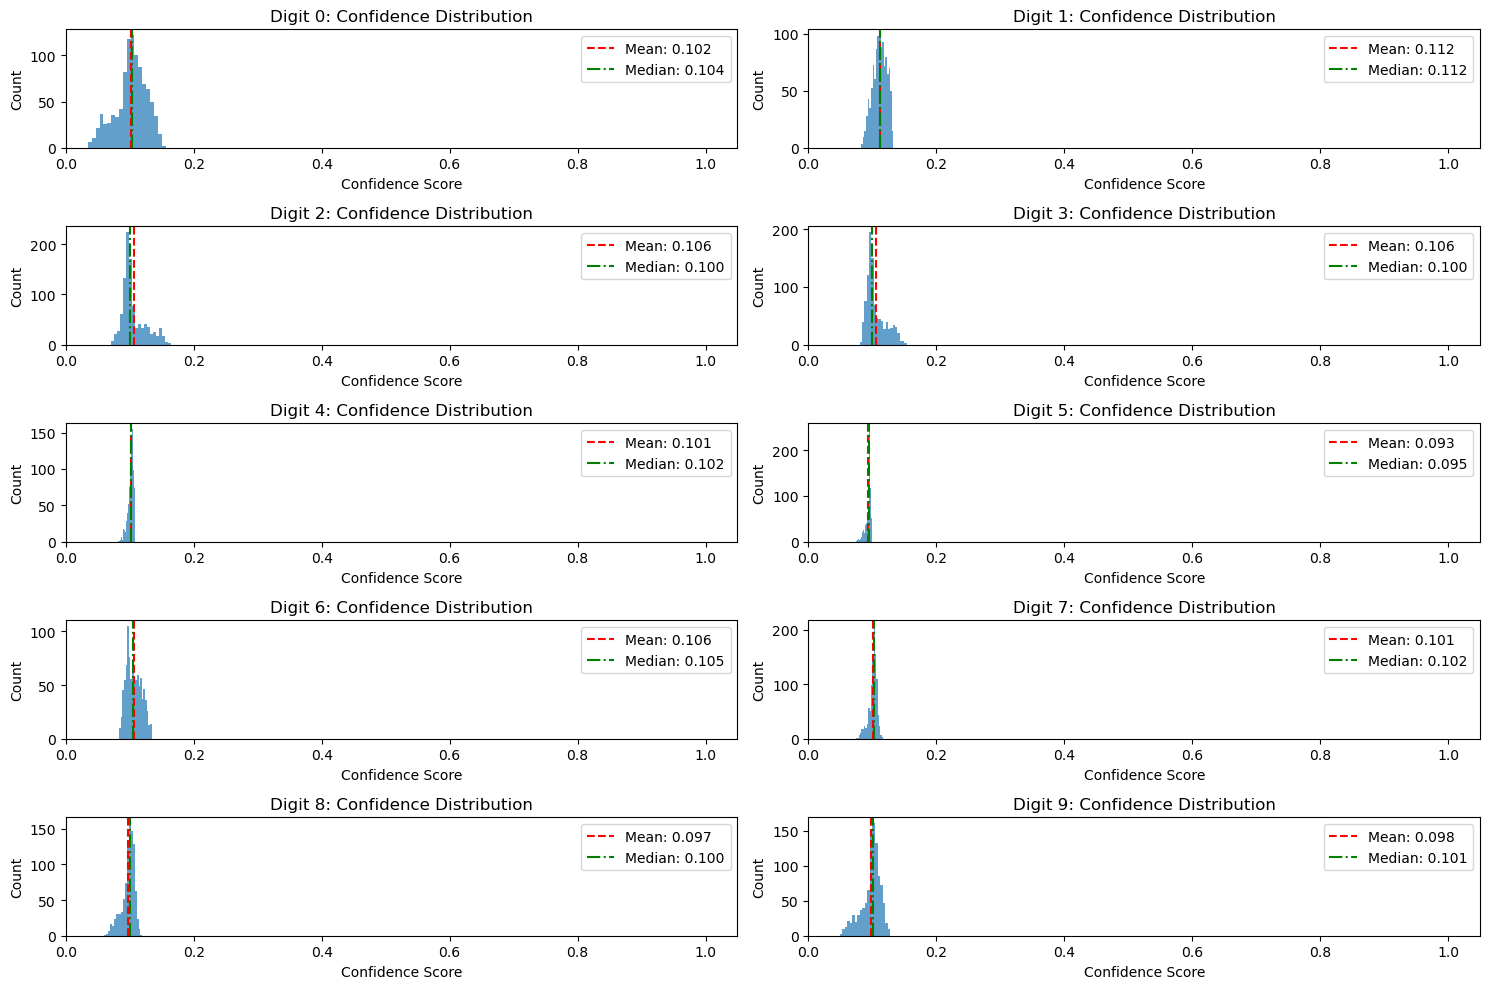

In [20]:
_ = visualize_prediction_matrix(classifier, testdata, dirpath=confusion_matrix_path)

In [21]:
# loaded_study = optuna.load_study(study_name="multimodal_dino", storage=f"sqlite:///{model_files_path}/studies.db")
# create_plots_for_study(loaded_study, versions_path=model_versions_path, plots_path=plots_trials_path)